In [1]:
import os
import glob
import iris
import pandas as pd
import numpy as np
import logging
import esmvalcore.preprocessor
import xarray as xr
import xesmf as xe
from tqdm import tqdm
from xmip.preprocessing import rename_cmip6
import matplotlib
import matplotlib.pyplot as plt
import dask
#from nc_processing import chunked_mean
from nc_processing import calc_spatial_mean
from tqdm import tqdm
import scipy.stats as stats
import seaborn as sns
import random
import cartopy.crs as ccrs
import cartopy.feature as cfeature



def read_in(dir, ocean = False):
    files = []
    for x in os.listdir(dir):
        files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, engine='netcdf4'))
    return ds

def read_in_ens_mean(dirs, ocean = False):
    """ returns (1) the ensemble mean dataset, and (2) the number of ensemble members """
    
    files = []
    for dir in dirs:
        for x in os.listdir(dir):
            if '.nc' in x:
                files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, concat_dim='ensemble',combine='nested'))
        n_ens = len(ds.ensemble) 
        ds = ds.mean(dim='ensemble')
        ds['number_ens_mems_meaned'] = n_ens
    return ds, n_ens

    
def read_in_ens(model, variable='pr', scenario='1pctCO2', table='Amon'):
    ens_mems = []

    for path in glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*p1*/{t}/{v}/*/latest/'.format(
    m=model, s=scenario, t=table, v=variable)):
        ens_mems.append(path.split('/')[9])
    
    ds_list = []
    for es in ens_mems:
        path = '/badc/cmip6/data/CMIP6/*/*/{m}/{s}/{e}/{t}/{v}/*/latest/'.format(
             m=model, s=scenario, e=es, t=table, v=variable)
        #files = os.listdir(path)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS, ens_mems
    
#def get_gmst(ds, var='tas'):
#    return calc_spatial_mean(ds[var].mean(dim="time"), lon_name="x", lat_name="y").values

def chunked_mean(ds, n, L, dim='year'):
    """
    Calculate mean values of n randomly sampled L-length 
    chunks along a specified dimension in an xarray dataset.

    Parameters:
        ds (xr.Dataset): The xarray dataset.
        n (int): Number of samples to return.
        L (int): Length of each chunk
        dim (str): The dimension along which to split the data (default: 'year').

    Note: n should be less than len(ds[dim]) - L
    
    Returns:
        list: list of the mean value for each chunk.
    """
    # check inputs match requirements:
    if not n < len(ds[dim])-L:
        print(' n should be less than len(ds[dim]) - L')
        return
    
    # Create an empty list to store mean values
    mean_values = []

    # Loop through and calculate mean for each chunk
    for i in range(n):
        max_i = len(ds[dim])-L
        start_idx = random.choice(np.arange(0, max_i, 1))
        chunk = ds.isel({dim: slice(start_idx, start_idx+L)})
        mean = chunk.mean(dim=dim).values*1
        mean_values.append(mean)

    return mean_values

drop_years_len = 75 # number of years at start of 2xco2 run to ignore
window_length = 20

import pickle

In [27]:
#mods = ['CanESM5', 'GISS-E2-1-H', 'HadGEM3-GC31-LL',
#       'IPSL-CM6A-LR', 'MIROC6']

mods_to_run = ['CanESM5', 'GISS-E2-1-H', 'HadGEM3-GC31-LL', 
               'IPSL-CM6A-LR', 'MIROC6', 'CESM2',
               'TaiESM1', 
               'MRI-ESM2-0', 
               'CNRM-CM6-1'] 
gws_mods = ['CESM2', 'TaiESM1', 'MRI-ESM2-0', 'CNRM-CM6-1']

In [28]:
### read in all
ds_list_1pctCO2 = []
ens_mems_list = []
for mod in mods_to_run:
    with open('int_outs/{}_dict.pickle'.format(mod), 'rb') as handle:
        d = pickle.load(handle)
    ds_tas, ens_mems = read_in_ens(model=mod, variable='tas', scenario='1pctCO2', table='Amon')
    ds_tas = ds_tas.groupby("time.year").mean(dim="time")
    ds_tas['Ensemble_member'] = ens_mems
    ds_tas['Model'] = mod
    ds_tas['Crossing_years'] = d['Crossing_years']
    ds_tas['Warming_rates_at_crossing_year'] = d['Warming_rates_at_crossing_year']
    ds_list_1pctCO2.append(ds_tas)

/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [29]:
### now select appropriate slice for each 1pctCO2 run
ds_1pctCO2_window_list=[]
i=0
mods_1pc = []
for ds in ds_list_1pctCO2:
    mod = ds.Model.item()
    mods_1pc.append(mod)
    ens_mems = ds.Ensemble_member
    j=0
    ds_es_list = []
    for es in ens_mems:
        ds_es = ds.sel(Ensemble_member=es)
        crossing_year = round(ds.Crossing_years.values[j])
        window = [crossing_year-9, crossing_year+9]
        ds_es = ds_es.sel(year=slice(window[0], window[1]))
        ds_es_list.append(ds_es)
        j=j+1
    ds_1pctCO2_window = xr.concat(ds_es_list, dim='Ensemble_member')
    ds_1pctCO2_window_list.append(ds_1pctCO2_window)
dict_1pctCO2 = dict(zip(mods_1pc, ds_1pctCO2_window_list))

In [30]:
### repeat to get the 2xCO2 runs:

ds_list_2xCO2 = []
drop_years_len = 75

for mod in mods_to_run:
    print(mod)
    if mod in gws_mods:
        dir_2x = glob.glob('/gws/nopw/j04/cpom/aduffey/Transient_baselines/abrupt-2xCO2/tas/{m}/'.format(m=mod))
    else:
        dir_2x = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/r1i*/Amon/tas/*/latest/'.format(m=mod, s='abrupt-2xCO2'))
    
    files_2x = os.listdir(dir_2x[0]) 
    paths_2x = []
    for x in files_2x:
        paths_2x.append(dir_2x[0]+x)
    da_2x = rename_cmip6(xr.open_mfdataset(paths_2x))
    da_2x = da_2x.groupby("time.year").mean(dim="time")
    da_2x = da_2x.isel(year=slice(drop_years_len,200)) #drop first N years ,keep only 75)) #drop first N years 
    ds_list_2xCO2.append(da_2x)
    
dict_2xCO2 = dict(zip(mods_to_run, ds_list_2xCO2))


CanESM5
GISS-E2-1-H
HadGEM3-GC31-LL
IPSL-CM6A-LR
MIROC6


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


CESM2


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


TaiESM1
MRI-ESM2-0
CNRM-CM6-1


In [31]:
### get ssp245 base in ukesm:
ens_mems_arise = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2']
### get crossing year  and warming rate at crossing 
## from pre-calculated ssp245 tas projections
df = pd.read_csv('int_outs/co2mass_at_crit_temp.csv')
df_base = df[df['Ensemble_member'].isin(ens_mems_arise)]
df_base = df_base[df_base['Scenario']=='ssp245']
#print(df_base)
crossing_year = np.mean(df_base['Crossing_year_1.5'])
arise_warming_rate = np.mean(df_base['Rate'])

In [32]:
var='tas'

In [91]:
### get arise and tas anom respect to transient base:

### make ARISE ensemble mean ds
ds_list = []
paths = glob.glob('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/*/Amon/{}/gn/*/'.format(var))
ens_mems = []
for path in paths:
    #files = os.listdir(path)
    ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
    ens_mem = path.split('/')[9]
    ens_mems.append(ens_mem)
    ds_list.append(ds)

DS_ARISE = xr.concat(ds_list, dim='Ensemble_member')
SAI = DS_ARISE.sel(time=slice('2051', '2070')).mean(dim='time')
SAI_em = SAI.mean(dim='Ensemble_member')

### make ssp245 ensemble mean ds (for appropriate ensemble members)
crossing_window = ['2013','2032'] # as calculated in 02B, the 20-year period closest to 1.5°C


def get_ssp245_ds(variable):
    ds_list = []
    for es in ens_mems:
        path = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/{e}/Amon/{v}/gn/latest/'.format(e=es, v=variable)
        #files = os.listdir(path)
        ds = rename_cmip6(xr.open_mfdataset(path+'*.nc'))
        ds_list.append(ds)
    
    DS = xr.concat(ds_list, dim='Ensemble_member')
    return DS
    
DS_ssp245 = get_ssp245_ds(var)


In [92]:
anomaly_list = []

for mod in mods_to_run:
    ds_1pc = dict_1pctCO2[mod]
    ds_2xc = dict_2xCO2[mod]
    anoms_es = []
    for i in range(len(ds_1pc.Ensemble_member)):
        ds_1pc_es = ds_1pc.isel(Ensemble_member=i)
        warming_1pc = ds_1pc['Warming_rates_at_crossing_year'][i].item()
        scale_factor=arise_warming_rate/warming_1pc
        print(mod, scale_factor)
        anom_es = scale_factor*(ds_2xc[var].mean(dim='year') - ds_1pc_es[var].mean(dim='year'))
        regridder = xe.Regridder(anom_es.to_dataset(), DS_ssp245, "nearest_s2d")
        anoms_es.append(regridder(anom_es, keep_attrs=True))
    anoms_mod = xr.concat(anoms_es, dim='Ensemble_member').load()
    anomaly_list.append(anoms_mod)
anoms_dict = dict(zip(mods_to_run, anomaly_list))

CanESM5 0.9698122358574092
CanESM5 1.0405234348982764
CanESM5 1.0662904532132003
GISS-E2-1-H 1.2866617585474422
HadGEM3-GC31-LL 0.8876198457751059
HadGEM3-GC31-LL 0.894598109643436
HadGEM3-GC31-LL 0.9790602771562424
HadGEM3-GC31-LL 0.8639546104054708
IPSL-CM6A-LR 1.1316306315367874
MIROC6 1.4636219549916711
CESM2 1.2278490438665879
TaiESM1 0.8528699778029166
MRI-ESM2-0 1.3431898308834367
CNRM-CM6-1 1.0842247376180818


In [93]:
baseline_tr = DS_ssp245.sel(time=slice(crossing_window[0], crossing_window[1])).mean(dim='time')
baseline_tr_em = baseline_tr.mean(dim='Ensemble_member')

ARISE_anom = (SAI-baseline_tr)
ARISE_anom_em = ARISE_anom.mean(dim='Ensemble_member')
ARISE_anom_em.load()


baseline_st = baseline_tr - anoms_dict['HadGEM3-GC31-LL'].mean(dim='Ensemble_member')

ARISE_anom_stabilised = (SAI-baseline_st)

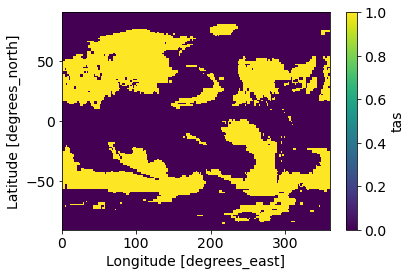

In [94]:
# also get a multi-model anoms dataset:

anoms_mm_ds = xr.concat([anom.mean(dim='Ensemble_member') for anom in anomaly_list], dim='Model')


# make a mask where at least N of 9 models agree on sign:
positives = xr.where(anoms_mm_ds>0, 1, 0)
N_positives = positives.sum(dim='Model')

negatives = xr.where(anoms_mm_ds<0, 1, 0)
N_negatives = negatives.sum(dim='Model')

N_required_to_agree = 8
models_agree_pve = xr.where(N_positives>=N_required_to_agree, 1, 0)
models_agree_nve = xr.where(N_negatives>=N_required_to_agree, 1, 0)
models_agree = models_agree_pve+models_agree_nve
models_agree.plot()

In [95]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [96]:
matplotlib.rcParams.update({'font.size': 14})

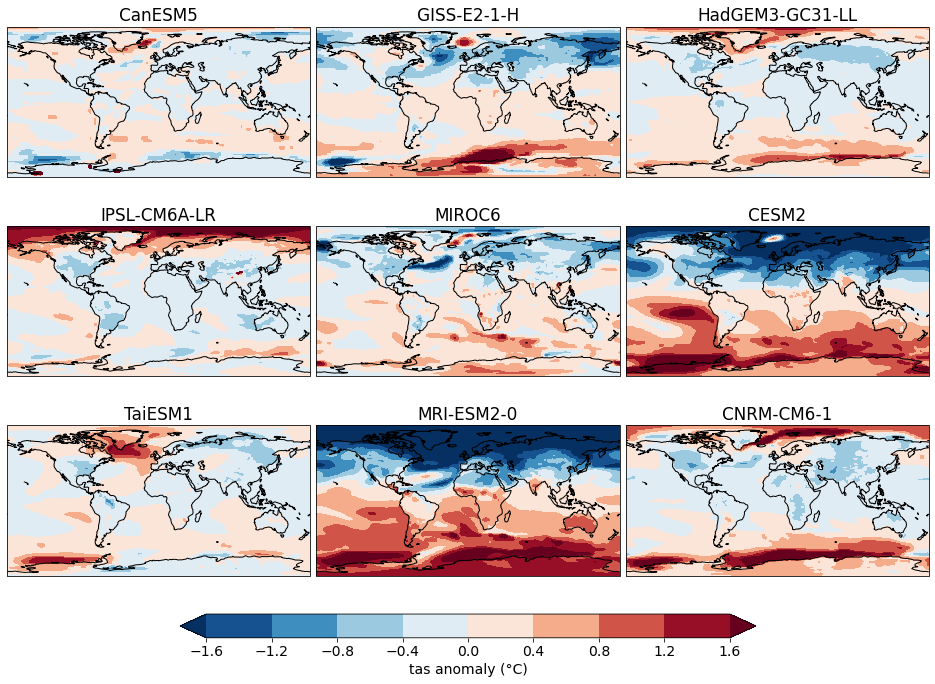

In [100]:
cols = 'RdBu_r'
clevs=np.arange(-1.6,2,0.4) 

fig, axs = plt.subplots(nrows=3,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,11))

i=0
    
for mod in mods_to_run:
    ax = axs.flatten()[i]
    esm = anoms_dict[mod].mean(dim='Ensemble_member')
    data,lons=add_cyclic_point(esm,coord=esm['x'])
    cs=ax.contourf(lons,esm['y'],data,clevs,
                   transform = ccrs.PlateCarree(),
                   cmap=cols,
                   extend='both')
    ax.set_title(mod)
    ax.coastlines()
    i=i+1
plt.tight_layout()
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)
cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='tas anomaly (°C)')
plt.savefig('Figures/spatial_tas_response_by_model.jpg', dpi=450)

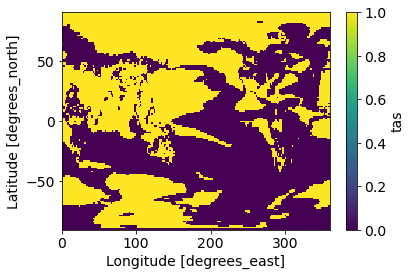

In [98]:
# get sig mask for ARISE:
positives = xr.where(ARISE_anom.tas>0, 1, 0)
N_positives = positives.sum(dim='Ensemble_member')

negatives = xr.where(ARISE_anom.tas<0, 1, 0)
N_negatives = negatives.sum(dim='Ensemble_member')

N_required_to_agree = 5 # out of 5 ensemble members
ems_agree_pve = xr.where(N_positives>=N_required_to_agree, 1, 0)
ems_agree_nve = xr.where(N_negatives>=N_required_to_agree, 1, 0)
ems_agree = ems_agree_pve+ems_agree_nve
ems_agree.plot()

/tmp/ipykernel_1056/4112196379.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


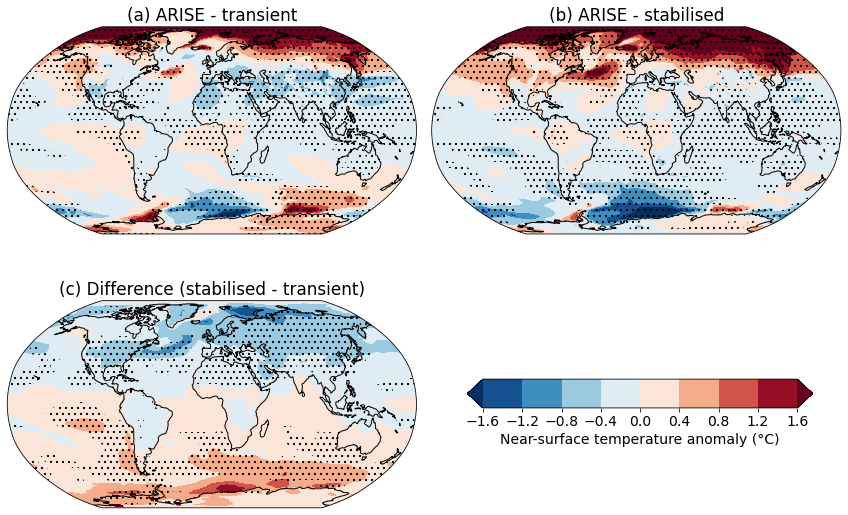

In [99]:
#cols = 'RdBu_r'
clevs=np.arange(-1.6,2,0.4) 

fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(12,8))

ax = axs.flatten()[2]
d = anoms_mm_ds.mean(dim='Model')
data,lons=add_cyclic_point(d,coord=d['x'])
cs=ax.contourf(lons,d['y'],data,clevs,
               transform = ccrs.PlateCarree(),
               cmap=cols,
               extend='both')

ax.set_title('(c) Difference (stabilised - transient)')
ax.coastlines()
sig_mask,lons=add_cyclic_point(models_agree, coord=models_agree['x'])
cs_hatch = ax.contourf(lons,models_agree['y'],sig_mask,
                       transform = ccrs.PlateCarree(),
                       levels=[0, 0.2, 1.2], colors='none',
                       hatches=[None,'..', '..'],
                       extend='neither', zorder=1000)


###################################################################
ax = axs.flatten()[0]
arise = ARISE_anom_em
data,lons=add_cyclic_point(arise.tas,coord=arise['x'])
cs=ax.contourf(lons,arise.y,data,clevs,
                   transform = ccrs.PlateCarree(),
                   cmap=cols,
                   extend='both')
ax.set_title('(a) ARISE - transient')

sig_mask,lons=add_cyclic_point(ems_agree, coord=ems_agree['x'])
cs_hatch = ax.contourf(lons, ems_agree['y'],sig_mask,
                       transform = ccrs.PlateCarree(),
                       levels=[0, 0.2, 1.2], colors='none',
                       hatches=[None,'..', '..'],
                       extend='neither', zorder=1000)
ax.coastlines()

###################################################################

ax = axs.flatten()[1]

ARISE_stable = ARISE_anom.tas-d
ARISE_stable_em = ARISE_stable.mean(dim='Ensemble_member')
# also get sig agreement:
positives, negatives = xr.where(ARISE_stable>0, 1, 0), xr.where(ARISE_stable<0, 1, 0)
N_positives, N_negatives = positives.sum(dim='Ensemble_member'), negatives.sum(dim='Ensemble_member')
N_required_to_agree = 5 # out of 5 ensemble members
ems_agree_st_pve, ems_agree_st_nve = xr.where(N_positives>=N_required_to_agree, 1, 0), xr.where(N_negatives>=N_required_to_agree, 1, 0) 
ems_agree_st = ems_agree_st_pve+ems_agree_st_nve
data,lons=add_cyclic_point(ARISE_stable_em,coord=ARISE_stable_em['x'])
cs=ax.contourf(lons,ARISE_stable_em.y,data,clevs,
                   transform = ccrs.PlateCarree(),
                   cmap=cols,
                   extend='both')

sig_mask,lons=add_cyclic_point(ems_agree_st, coord=ems_agree_st['x'])
cs_hatch = ax.contourf(lons, ems_agree_st['y'],sig_mask,
                       transform = ccrs.PlateCarree(),
                       levels=[0, 0.2, 1.2], colors='none',
                       hatches=[None,'..', '..'],
                       extend='neither', zorder=1000)
ax.set_title('(b) ARISE - stabilised')
ax.coastlines()

###################################################################

ax = axs.flatten()[3].remove()

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.55, 0.25, 0.4, 0.05])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal', label='Near-surface temperature anomaly (°C)')
plt.tight_layout()
plt.savefig('Figures/spatial_tas_response.jpg', dpi=450)